In [1]:
#!/usr/bin/env python

import math
import healpy as hp
import numpy as np
import sys
import time
import os
sys.path.insert(1, '../../../PySSC/')

from classy import Class
import PySSC
from scipy.stats import norm
from matplotlib import pyplot as plt

from numcosmo_py import Ncm, Nc

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

In [2]:
cosmo_resample = Nc.HICosmoDEXcdm()
cosmo_resample.props.H0 = 67.81
cosmo_resample.props.Omegac = 0.3
cosmo_resample.props.Omegab = 0.0486
cosmo_resample.props.Omegax = 1 - 0.0486 - 0.3
cosmo_resample.props.w = -1.3

reion_resample = Nc.HIReionCamb.new()
prim_resample = Nc.HIPrimPowerLaw.new()

cosmo_resample.add_submodel(reion_resample)
cosmo_resample.add_submodel(prim_resample)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
prim_resample.props.n_SA = 0.9660


prim_resample.props.ln10e10ASA = 3.427449698161606


z_obs = Ncm.Vector.new_array(np.linspace(0.1, 0.8, 8))
lnM_obs = Ncm.Vector.new_array(np.linspace(np.log(10) * 14.0, np.log(10) * 15, 2))

print(z_obs.dup_array())
print(lnM_obs.dup_array())
print(prim_resample.props.ln10e10ASA)

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8]
[32.23619130191664, 34.53877639491069]
2.727449698161606


# Construct the $S_{ij}$  Matrix

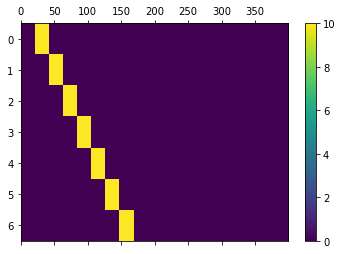

In [3]:
nz = 400
z_arr = np.linspace(0, 1.9, num=nz + 1)[1:]

nbins_T = z_obs.len() - 1

kernels_T = np.zeros((nbins_T, nz))
for i in range(nbins_T):
    zminbin = z_obs.get(i)
    zmaxbin = z_obs.get(i + 1)
    Dz = zmaxbin - zminbin

    for iz in range(nz):
        z = z_arr[iz]
        if (z > zminbin) and (z <= zmaxbin):
            kernels_T[i, iz] = 1 / Dz

fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.matshow(kernels_T)
ax.set_aspect("auto")
plt.colorbar(im)
pass

In [4]:
NSIDE = 2 * 512
NPIX = hp.nside2npix(NSIDE)
m = np.zeros(hp.nside2npix(NSIDE))
pix_theta_ecl, pix_phi_ecl = hp.pix2ang(NSIDE, np.arange(NPIX))

# Guaranteed mask
mask1_guaranteed = np.zeros(NPIX)
mask2_guaranteed = np.zeros(NPIX)
mask3_guaranteed = np.zeros(NPIX)

mask1_guaranteed_condition = (
    (pix_phi_ecl > 3.0 * np.pi / 4.0)
    & (pix_phi_ecl < 13.0 * np.pi / 12.0)
    & (pix_theta_ecl < np.pi / 2.0 - 30.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_guaranteed_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)
mask3_guaranteed_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)

mask1_guaranteed[mask1_guaranteed_condition] = 1
mask2_guaranteed[mask2_guaranteed_condition] = 1
mask3_guaranteed[mask3_guaranteed_condition] = 1

mask_guaranteed = mask1_guaranteed + mask2_guaranteed + mask3_guaranteed

# Total mask
mask1_full = np.zeros(NPIX)
mask2_full = np.zeros(NPIX)
mask3_full = np.zeros(NPIX)

mask1_full_condition = (
    (pix_phi_ecl > 2.0 * np.pi / 3.0)
    & (pix_phi_ecl < 3.0 * np.pi / 2.0)
    & (pix_theta_ecl < np.pi / 2.0 - 10.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_full_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)
mask3_full_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)

mask1_full[mask1_full_condition] = 1
mask2_full[mask2_full_condition] = 1
mask3_full[mask3_full_condition] = 1

mask_full = mask1_full + mask2_full + mask3_full

`S matrices`

In [5]:
cosmo_sij = Nc.HICosmoDEXcdm()
cosmo_sij.props.H0 = 67.81
cosmo_sij.props.Omegac = 0.2612
cosmo_sij.props.Omegab = 0.0486
cosmo_sij.props.Omegax = 1 - 0.0486 - 0.2612
cosmo_sij.props.w = -1.0

reion_sij = Nc.HIReionCamb.new()
prim_sij = Nc.HIPrimPowerLaw.new()

prim_sij.props.ln10e10ASA = 3.027449698161606

cosmo_sij.add_submodel(reion_sij)
cosmo_sij.add_submodel(prim_sij)

# Full sky
t0 = time.time()
S_lacasa_full = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo_sij)
t1 = time.time()
print("Full sky time (seconds) = " + str(t1 - t0))

S_full = Ncm.Matrix.new(S_lacasa_full.shape[0], S_lacasa_full.shape[1])
for i in range(len(S_lacasa_full)):
    for j in range(len(S_lacasa_full[i])):
        S_full.set(i, j, S_lacasa_full[i][j])


S_full.log_vals("Sij: ", "% 22.15g")

Full sky time (seconds) = 0.5293445587158203


# Define proxy modelling

In [6]:
cluster_m = Nc.ClusterMassNodist(lnM_min=np.log(10) * 14.0, lnM_max=np.log(10) * 16 )
cluster_z = Nc.ClusterRedshiftNodist(z_min=0.0, z_max=2.0)

# Initialize the `ClusterAbundance` object

In [7]:
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, hbias_Tinker)
cad.prepare(cosmo_resample, cluster_z, cluster_m)

for z in range(z_obs.len()-1):
    print(cad.intp_bin_d2n(cosmo_resample, cluster_z,cluster_m , [lnM_obs.get(0)],[lnM_obs.get(1)],None, [z_obs.get(z)],[z_obs.get(z+1)],None))

: 

: 

# Data model

$f(x_i)$ for the Gaussian distribution $$-2\ln L = \sum_{ij}\left[(f(x_i) - y_i)C^{-1}_{ij}(f(x_j) - y_j)\right] + \dots$$

In [ ]:
mset_fiducial = Ncm.MSet.new_array([cosmo_resample,cluster_m,cluster_z])
mset_sij = Ncm.MSet.new_array([cosmo_sij,cluster_m,cluster_z])
ser = Ncm.Serialize.new(Ncm.SerializeOpt.NONE)

ncounts_gauss = Nc.DataClusterNCountsGauss.new(cad)
ncounts_gauss.set_size((z_obs.len()-1)*(lnM_obs.len()-1))
ncounts_gauss.set_init(True)
ncounts_gauss.set_fix_cov(False)
ncounts_gauss.use_norma(True)
ncounts_gauss.set_z_obs(z_obs)
ncounts_gauss.set_lnM_obs(lnM_obs)
rng = Ncm.RNG.seeded_new (None, 42)

False


# Creating the fit object and calculating the MC

In [ ]:
print("Full sky MC fixed cov")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.resample(mset_sij, rng)

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")
ncounts_gauss.set_fix_cov(True)
print(ncounts_gauss.get_fix_cov())


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo_sij.props.Omegac_fit = True
cosmo_sij.props.Omegab_fit = False
cosmo_sij.props.w_fit = True
prim_sij.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_fiducial))


mset_full = mset_sij.dup(ser)
mset_full.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_full, Ncm.FitGradType.NUMDIFF_FORWARD
)


fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.FULL)
fitmc.set_fiducial(mset_fiducial)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_fullsky_3parameters_fixedcov.fits")

fitmc.start_run()
fitmc.run(500)
fitmc.end_run()


print("Full sky guaranteed time (seconds) = " + str(t1 - t0))
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")

In [ ]:
print("Full sky MC")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_s_matrix(S_full)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.set_fix_cov(False)
print(ncounts_gauss.get_fix_cov())

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo_sij.props.Omegac_fit = True
cosmo_sij.props.Omegab_fit = False
cosmo_sij.props.w_fit = True
prim_sij.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_fiducial))


mset_full = mset_sij.dup(ser)
mset_full.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_full, Ncm.FitGradType.NUMDIFF_FORWARD
)


fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.FULL)
fitmc.set_fiducial(mset_fiducial)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_fullsky_3parameters.fits")

fitmc.start_run()
fitmc.run(500)
fitmc.end_run()


print("Full sky guaranteed time (seconds) = " + str(t1 - t0))